Part 2
------------------------------------------------------------------------
Laura Silvana Alvarez, Florencia Luque and Simon Schmetz

In the first step, we will compare different types of clustering using the K-Means algorithm. The first approach focuses solely on numeric variables, comparing two scenarios: one using the raw data (excluding variables with high correlations) and another using the PCA components derived in the first part of the analysis.

For the second approach, K-Means will be applied to mixed data, combining both numeric and categorical variables.

# Kmeans with PCA data

In [2]:
### import libraries

# format
import pandas as pd

# plot
import matplotlib.pyplot as plt

# math
import numpy as np
from scipy.linalg import inv, det
from numpy.linalg import eig

#kmeans 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#kmeans mixto
from kmodes.kprototypes import KPrototypes
from dython.nominal import associations
from sklearn.preprocessing import OneHotEncoder
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
#function to create summary of kmeans
def summarize_clusters(df,cluster_column, numeric_cols, categorical_cols, binary_col):
    cluster_summary = []
    
    for cluster in sorted(df[cluster_column].unique()):
        cluster_data = df[df[cluster_column] == cluster]
        summary = {}
        
        # mean for numeric variables
        for col in numeric_cols:
            summary[col] = cluster_data[col].mean()
        
        # mode for categorical variables
        for col in categorical_cols:
            summary[col] = cluster_data[col].mode()[0]  # mode()[0] gives the most frequent value
        
        # percentage of 1's for the binary column
        total_count = len(cluster_data)
        count_ones = cluster_data[binary_col].sum()
        percentage_ones = (count_ones / total_count) * 100
        summary[f'{binary_col}_percentage'] = round(percentage_ones, 2)
        
        # Add cluster label
        summary[cluster_column] = cluster
        cluster_summary.append(summary)
    
    # Convert summary list to a DataFrame
    summary_df = pd.DataFrame(cluster_summary)
    return summary_df


In [4]:
def scatterplot_pc(df, x_col, y_col, hue_col=None, ax=None, expl_var=None):
    # plot
    sns.scatterplot(data=df, 
                    x=x_col, 
                    y=y_col, 
                    hue=hue_col,
                    palette='Set1',
                    ax=ax)
    
    # cosmetics
    title = f'Scatter Plot of {y_col} vs {x_col}'
    if expl_var is not None:
        title += f' \n Joined explained variance: {expl_var} %'
    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.7)


In [5]:
# load data
data_pca = pd.read_csv("data_pca.csv")
data_pca = data_pca.drop(columns=["Unnamed: 0","PC4","PC5","PC6","PC7","index"])
data_raw = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

In [6]:
### Preprocess Data
data = data_raw.copy()

# rename columns for easier use
rename_dict = {
    'Person ID':'person_id',
    'Gender': 'gender',
    'Age':'age',
    'Occupation':'occupation',
    'Sleep Duration':'sleep_duration',
    'Quality of Sleep':'quality_of_sleep',
    'Physical Activity Level':'physical_activity_level',
    'Stress Level':'stress_level',
    'BMI Category':'bmi_category', 
    'Blood Pressure':'blood_pressure', 
    'Heart Rate':'heart_rate', 
    'Daily Steps':'daily_steps',
    'Sleep Disorder':'sleep_disorder' 
}
data.rename(columns=rename_dict, inplace=True)

# change dtype
data['quality_of_sleep'] = data['quality_of_sleep'].astype(str)
data['stress_level'] = data['stress_level'].astype(str)

# make sleep disorder binary
data['sleep_disorder'] = data['sleep_disorder'].map(lambda x: '1' if x in ['Insomnia','Sleep Apnea'] else '0').astype(str)

# split blood pressure into diastolic & systolic
data[["blood_pressure_systolic","blood_pressure_diastolic"]] = data["blood_pressure"].str.split('/',expand=True)
data["blood_pressure_diastolic"] = pd.to_numeric(data['blood_pressure_diastolic'])
data["blood_pressure_systolic"] = pd.to_numeric(data["blood_pressure_systolic"])

#data.info()

In [7]:
# # set up column lists
numeric_variables = ['age','sleep_duration','physical_activity_level','heart_rate','daily_steps','blood_pressure_systolic','blood_pressure_diastolic']
categorical_variables = ['gender','occupation','quality_of_sleep','stress_level','bmi_category','sleep_disorder']
# data.nunique()

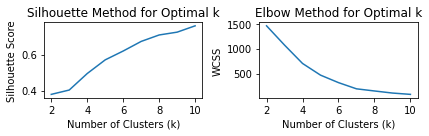

In [8]:
X_pca = data_pca[['PC1','PC2','PC3']]
silhouette_scores = []
inertia = []
for k in range(2, 11):  # Silhouette score is undefined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    score = silhouette_score(X_pca, kmeans.labels_)
    silhouette_scores.append(score)
    inertia.append(kmeans.inertia_)
# Plotting the Silhouette Scores
fig, axs = plt.subplots(1,2,figsize=(6,2))
axs[0].plot(range(2, 11), silhouette_scores)
axs[0].set_title('Silhouette Method for Optimal k')
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('Silhouette Score')
axs[1].plot(range(2, 11), inertia)
axs[1].set_title('Elbow Method for Optimal k')
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('WCSS')
plt.tight_layout()
plt.show()

If we compare the graphs, there is stabilization between 5 and 7 clusters in the Silhouette method. Similarly, in the Elbow method, the slope becomes less steep around 5 and 7 clusters.

In [9]:

# Step 2: Perform K-Means clustering on the reduced data
#kmeans = KMeans(n_clusters=5, random_state=14, init="random", n_init=30)
#kmeans.fit(X_pca)

# Get the cluster labels
#labels = kmeans.labels_

# Checking clusters (silently store metrics without printing)
#inertia = kmeans.inertia_
#sil_score = silhouette_score(X_pca, kmeans.labels_)


Between the cluster 3 and 1 is some elapsing data within the PC1 vs PC2. This also ocurre within the 1 and the 0 in the PC1 vs PC3. The other clusters all well separarted in the first factorial plane.

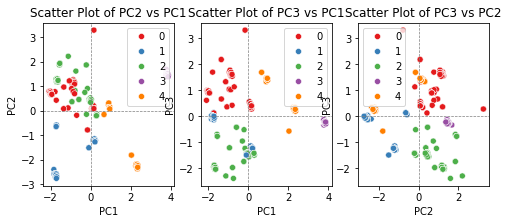

Inertia (WCSS): 514.3050509930852
Silhouette Score: 0.5293026167347402


In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Step 2: Perform K-Means clustering on the reduced data
kmeans = KMeans(n_clusters=5, random_state=14, init="random", n_init=30)
kmeans.fit(X_pca)

# Get the cluster labels
labels = kmeans.labels_
data_pca['Cluster'] = kmeans.labels_
# Step 3: Visualize the results
#cmap='viridis'

fig, axs = plt.subplots(1, 3, figsize=(8, 3))
scatterplot_pc(data_pca,x_col="PC1",y_col = "PC2", hue_col=labels,ax = axs[0])
scatterplot_pc(data_pca,x_col="PC1",y_col = "PC3", hue_col=labels,ax = axs[1])
scatterplot_pc(data_pca,x_col="PC2",y_col = "PC3", hue_col=labels,ax = axs[2])
plt.show()

# CHECKING THE CLUSTERS
# Get the inertia (WCSS)
inertia = kmeans.inertia_
print(f"Inertia (WCSS): {inertia}")
# Assuming kmeans.labels_ contains the cluster labels
sil_score = silhouette_score(X_pca, kmeans.labels_)
print(f"Silhouette Score: {sil_score}")


If we use 5 cluster there's seem to be more clarity between the clusters. The silhouette is also almost over 0.5 and it visible in the graphs. 

If we compare the information we can said that the best number of cluster for the PCA data is 7, but we decide to keep 5, because it does not make sense to have that amount of clusters when the sample is not that large.

The principal characteristics of the clusters are given in the next table. Where in the categorical variables we have the mode of the cluster, and in the end we have the proportion of the cluster that has sleep disorders.

- In cluster 2 and 4 it is shown that there are more nurse females with overweight. Despite the fact that the cluster 0 has a good perception of their quality of sleep, it is shown that both clusters have the biggest % sleep disorder (over 90%)

- Cluster 3 have the lowest proportions of sleep disorder, most of the members of this cluster are men, lawyers with a normal bmi.

In general it can be concluded that the perception of the sleep quality is not directly related with having or not a sleep disorder.

In [11]:
pca_sumary = summarize_clusters(data_pca,'Cluster', numeric_variables, categorical_variables,"sleep_disorder")
pca_sumary[categorical_variables+['sleep_disorder_percentage']]


,gender,occupation,quality_of_sleep,stress_level,bmi_category,sleep_disorder,sleep_disorder_percentage
0,Male,Doctor,8,4,Normal,0,4.59
1,Female,Engineer,9,3,Normal,0,40.00
2,Male,Salesperson,6,7,Overweight,0,48.78
3,Female,Nurse,6,8,Overweight,1,93.75
4,Female,Nurse,8,5,Normal,1,51.52


In [12]:
pca_sumary[numeric_variables]

,age,sleep_duration,physical_activity_level,heart_rate,daily_steps,blood_pressure_systolic,blood_pressure_diastolic
0,35.550459,7.402752,65.293578,68.880734,7680.733945,120.724771,79.376147
1,47.646154,7.558462,38.538462,65.000000,5415.384615,129.153846,84.153846
2,38.731707,6.320732,39.560976,72.146341,5734.146341,127.256098,82.865854
3,49.750000,6.065625,90.000000,75.000000,10000.000000,140.000000,95.000000
4,50.060606,7.922727,82.500000,69.060606,7439.393939,135.000000,90.000000


### Kmeans with raw data
For this, we need data without strong correlations. The variables related to blood pressure have a high correlation of almost 0.97. To avoid losing any information, we decided to create a new variable called pulse pressure. Pulse pressure is calculated as the difference between systolic and diastolic blood pressure.

In [13]:
data["pulse_pressure"] = data['blood_pressure_systolic']-data['blood_pressure_diastolic'] 
data_k = data.copy()
data_kmeans= data[numeric_variables+['pulse_pressure']]
data_kmeans = data_kmeans.drop(columns=['blood_pressure_systolic','blood_pressure_diastolic'])
data_kmeans[['age', 'sleep_duration', 'physical_activity_level', 'heart_rate',
       'daily_steps', 'pulse_pressure']] = StandardScaler().fit_transform(data_kmeans[['age', 'sleep_duration', 'physical_activity_level', 'heart_rate',
       'daily_steps', 'pulse_pressure']])

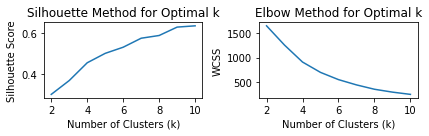

In [14]:
silhouette_scores = []
inertia = []
for k in range(2, 11):  # Silhouette score is undefined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_kmeans)
    score = silhouette_score(data_kmeans, kmeans.labels_)
    silhouette_scores.append(score)
    inertia.append(kmeans.inertia_)
# Plotting the Silhouette Scores
fig, axs = plt.subplots(1,2,figsize=(6,2))
axs[0].plot(range(2, 11), silhouette_scores)
axs[0].set_title('Silhouette Method for Optimal k')
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('Silhouette Score')
axs[1].plot(range(2, 11), inertia)
axs[1].set_title('Elbow Method for Optimal k')
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('WCSS')
plt.tight_layout()
plt.show()

If you compare the two graphs, there is stabilization around 4 clusters in the Silhouette Score graph and a noticeable decrease in the slope (tangent) in the Elbow Method graph. However, using 5 clusters appears slightly better, as it balances both metrics.


In [15]:
# 4 clusters
data_kmeans_5 = data_kmeans.copy()
# Step 2: Perform K-Means clustering on the raw data
kmeans = KMeans(n_clusters=5, random_state=14, init="random", n_init=30)
kmeans.fit(data_kmeans_5)

# Add cluster labels to the DataFrame
data_kmeans_5['Cluster'] = kmeans.labels_

# CHECKING THE CLUSTERS
# Get the inertia (WCSS)
inertia = kmeans.inertia_
print(f"Inertia (WCSS): {inertia}")

sil_score = silhouette_score(data_kmeans_5, kmeans.labels_)
print(f"Silhouette Score: {sil_score}")


Inertia (WCSS): 694.6414160666793
Silhouette Score: 0.5610595002325737


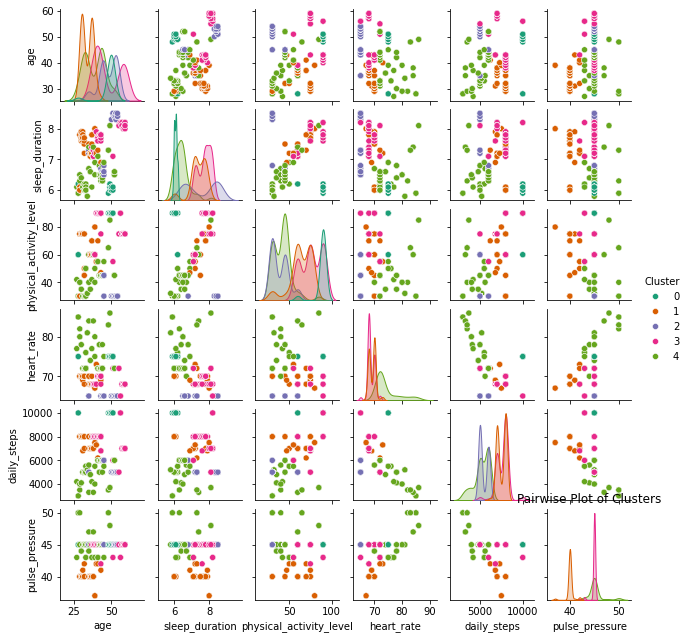

Inertia (WCSS): 694.6414160666793
Silhouette Score: 0.5610595002325737


In [16]:
# Add cluster labels to the DataFrame
data_k['Cluster'] = kmeans.labels_

# Create pairplot to visualize the clusters
sns.pairplot(data_k[['age', 'sleep_duration', 'physical_activity_level', 'heart_rate',
       'daily_steps', 'pulse_pressure','Cluster']], hue='Cluster', palette='Dark2',height=1.5)
plt.title('Pairwise Plot of Clusters')
plt.show()

inertia = kmeans.inertia_
print(f"Inertia (WCSS): {inertia}")

sil_score = silhouette_score(data_kmeans_5, kmeans.labels_)
print(f"Silhouette Score: {sil_score}")


There is a larger decrease in WCSS and a slight improvement in the Silhouette Score when choosing 5 clusters. Additionally, using PCA to visualize the data reveals better separation of the clusters compared to 4 clusters. Choosing 5 clusters reduces overlaps between the groups, providing a more distinct and interpretable clustering structure.

The data description for the cluster is as follows.

In [17]:
data_k['sleep_disorder'] = pd.to_numeric(data_k['sleep_disorder'])
kmeans_raw_sum = summarize_clusters(data_k,'Cluster', numeric_variables, categorical_variables,'sleep_disorder')

In [18]:
kmeans_raw_sum[categorical_variables+['sleep_disorder_percentage']]

,gender,occupation,quality_of_sleep,stress_level,bmi_category,sleep_disorder,sleep_disorder_percentage
0,Female,Nurse,6,8,Overweight,1,88.24
1,Male,Doctor,8,4,Normal,0,4.71
2,Female,Engineer,9,3,Normal,0,40.00
3,Male,Lawyer,8,5,Normal,0,37.89
4,Male,Salesperson,6,7,Overweight,1,62.11


In [19]:
kmeans_raw_sum[numeric_variables]

,age,sleep_duration,physical_activity_level,heart_rate,daily_steps,blood_pressure_systolic,blood_pressure_diastolic
0,48.470588,6.073529,88.235294,75.000000,10000.000000,139.117647,94.117647
1,33.882353,7.362353,63.788235,69.176471,7510.588235,117.894118,77.847059
2,47.646154,7.558462,38.538462,65.000000,5415.384615,129.153846,84.153846
3,47.031579,7.735789,76.368421,68.715789,7618.947368,133.084211,88.178947
4,38.778947,6.409474,41.557895,74.305263,5213.684211,129.368421,84.157895


### Kmeans with mixed data 
For this, we will also use the pulse pressure variable and exclude the sleep disorder variable. This is because the sleep disorder variable is the target variable that this dataset aims to explain.

In [20]:
data_kprot = data[numeric_variables+categorical_variables+['pulse_pressure']]

Now we have the assosiations between numerical and categorical variables finding some interesting relationships:
- Age is highly associated with occupation, quality of sleep and stress level.
- The hear rate is associated with quality of sleep, stress level and BMI category.
- Other important relations are gender with occupation and sleep disorder with bmi category.

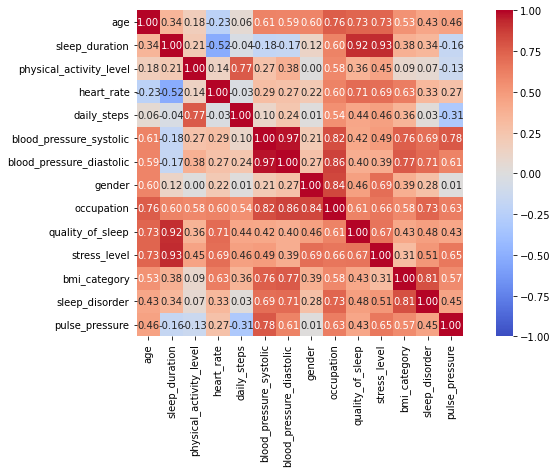

In [21]:
# Generate only the plot
_ = associations(data_kprot, 
                 nominal_columns=categorical_variables, 
                 plot=True, 
                 cmap="coolwarm",
                 figsize=(12,6))

plt.show()  # Display the plot


In [22]:
data_kp = data_kprot.copy()
data_kprot[numeric_variables+['pulse_pressure']] = StandardScaler().fit_transform(data_kprot[numeric_variables+['pulse_pressure']])
data_kprot = data_kprot.drop(columns=['blood_pressure_systolic','blood_pressure_diastolic'])


In [23]:
label_encoders = {}
for col in categorical_variables:
    le = LabelEncoder()
    data_kprot[col] = le.fit_transform(data_kprot[col])
    label_encoders[col] = le

In [24]:
data_aux = data_kprot.drop(columns=['sleep_disorder'])

In [25]:
data_array = data_aux.to_numpy()
categorical_variables_sub = ['gender',
 'occupation',
 'quality_of_sleep',
 'stress_level',
 'bmi_category']

In [26]:
encoder = OneHotEncoder(sparse_output=False)
categorical_encoded = encoder.fit_transform(data_aux[categorical_variables_sub])

# Combine the numeric and encoded categorical data
numeric_variables_sub = data_aux.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_data = data_aux[numeric_variables_sub].to_numpy()
combined_data = np.hstack((numeric_data, categorical_encoded))

cost = []
silhouette_scores = []
for cluster in range(2, 13):
    try:
        kprototype = KPrototypes(n_jobs=-1, n_clusters=cluster, n_init=30, init='Huang', random_state=123)
        cluster_labels = kprototype.fit_predict(data_aux.to_numpy(), 
                                                categorical=[data_aux.columns.get_loc(col) for col in categorical_variables_sub])
        cost.append(kprototype.cost_)

        score_aux = silhouette_score(combined_data, cluster_labels, metric='euclidean')
        silhouette_scores.append(score_aux)

    except Exception as e:
        print(f"Error for cluster {cluster}: {e}")
        break

fig, axs = plt.subplots(1, 2, figsize=(6, 2))

# Silhouette Score Plot
axs[0].plot(range(2, 13), silhouette_scores, marker='o')
axs[0].set_title('Silhouette Method for Optimal k')
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('Silhouette Score')

# Elbow Plot (Cost)
axs[1].plot(range(2, 13), cost, marker='o')
axs[1].set_title('Elbow Method for Optimal k')
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('WCSS')

plt.tight_layout()
plt.show()


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse_output'

In this case the elbow method does not show a clear point where the trend of the line change, but the silhouette method suggest to take 6 or 8 clusters. 

In [63]:
# Ensure the categorical variables are properly encoded for K-Prototypes
data_kprot8 = data_aux.copy()
data_array = data_kprot8.to_numpy()

# Perform K-Prototypes clustering
kproto = KPrototypes(n_clusters=8, init='Huang', n_init=15, random_state=42)
cluster_labels = kproto.fit_predict(data_array, 
                                    categorical=[data_kprot8.columns.get_loc(col) for col in categorical_variables_sub])

# Add cluster labels to the DataFrame
data_kprot8['Cluster_8'] = cluster_labels

# Get the inertia (WCSS)
inertia = kproto.cost_
print(f"Inertia (WCSS): {inertia}")
# Convert categorical variables to numeric
encoder = OneHotEncoder(sparse_output=False)
categorical_encoded = encoder.fit_transform(data_kprot8[categorical_variables_sub])
numeric_data = data_kprot8[['age', 'sleep_duration', 'physical_activity_level', 'heart_rate', 'daily_steps','pulse_pressure']].to_numpy()

# Combine numeric and encoded categorical features
combined_data = np.hstack((numeric_data, categorical_encoded))

# Compute silhouette score
sil_score = silhouette_score(combined_data, cluster_labels)
print(f"Silhouette Score: {sil_score}")


Inertia (WCSS): 648.395347535735
Silhouette Score: 0.5281157797233468


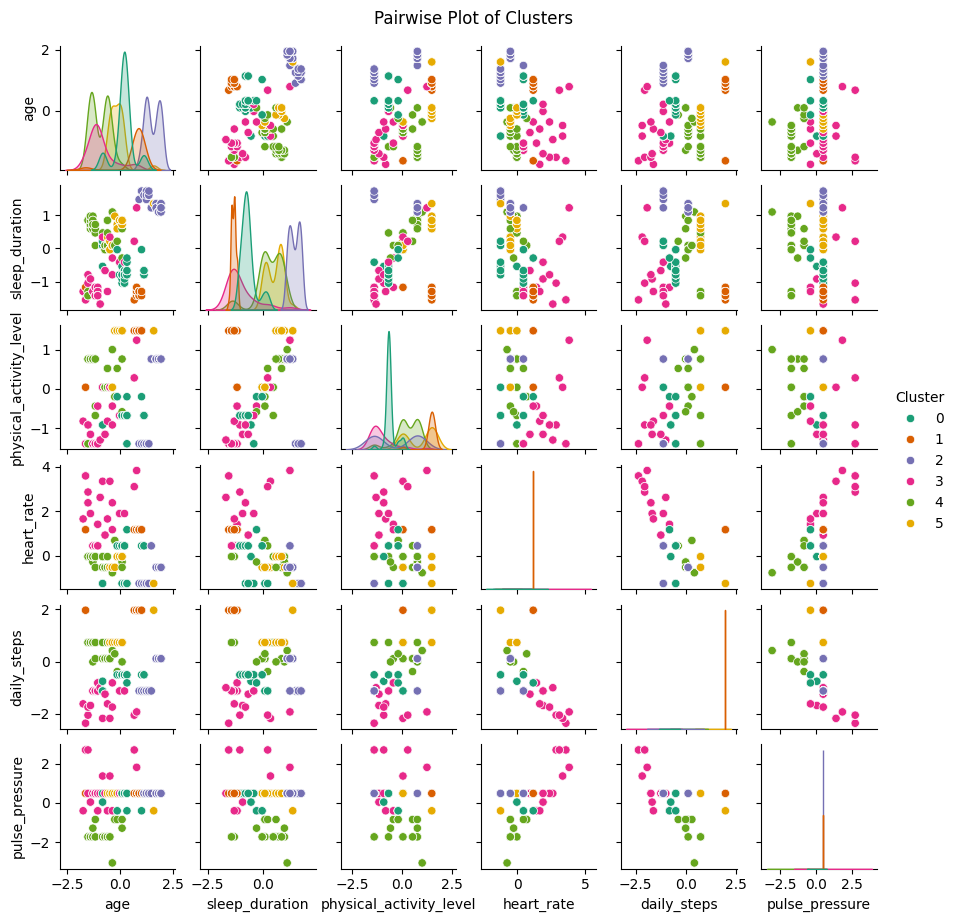

Inertia (WCSS): 848.3962463374016
Silhouette Score: 0.4566891534481832


In [64]:
# Ensure the categorical variables are properly encoded for K-Prototypes
data_kprot6 = data_aux.copy()
data_array = data_kprot6.to_numpy()

# Perform K-Prototypes clustering
kproto = KPrototypes(n_clusters=6, init='Huang', n_init=15, random_state=42)
cluster_labels = kproto.fit_predict(data_array, 
                                    categorical=[data_kprot6.columns.get_loc(col) for col in categorical_variables_sub])

# Add cluster labels to the DataFrame
data_kprot6['Cluster'] = cluster_labels
data_kp['Cluster'] = cluster_labels

# Create pairplot to visualize the clusters
sns.pairplot(data_kprot6[['age', 'sleep_duration', 'physical_activity_level', 'heart_rate', 'daily_steps', 'Cluster', 'pulse_pressure']], 
             hue='Cluster', palette='Dark2',height=1.5)
plt.suptitle('Pairwise Plot of Clusters', y=1.02)
plt.show()

# Get the inertia (WCSS)
inertia = kproto.cost_
print(f"Inertia (WCSS): {inertia}")
# Convert categorical variables to numeric
encoder = OneHotEncoder(sparse_output=False)
categorical_encoded = encoder.fit_transform(data_kprot6[categorical_variables_sub])
numeric_data = data_kprot6[['age', 'sleep_duration', 'physical_activity_level', 'heart_rate', 'daily_steps','pulse_pressure']].to_numpy()

# Combine numeric and encoded categorical features
combined_data = np.hstack((numeric_data, categorical_encoded))

# Compute silhouette score
sil_score = silhouette_score(combined_data, cluster_labels)
print(f"Silhouette Score: {sil_score}")



If we compared the silhouette score and the cost. The best quantity of cluster for the mixed kmeans is 8 clusters. But taking into account the size of the data base, we consider that 8 clusters are too much, so we decide to keep 6.

In [65]:
data_kp['sleep_disorder'] = pd.to_numeric(data_kp['sleep_disorder'])

What we see before about the positive association of the bmi category and occupation with having or not sleep disorder is reflected in the clusters 0 and 1 where orverweight and being a Nurse/Salesperson increase the ratio of sleep disorder.

From cluster number 4 and the association matrix we can infere that the bmi category is the principal driver for having or not a sleep disorder.

In [66]:
sum_kproto = summarize_clusters(data_kp,'Cluster',numeric_variables,categorical_variables,'sleep_disorder')
sum_kproto[categorical_variables+['sleep_disorder_percentage']]

,gender,occupation,quality_of_sleep,stress_level,bmi_category,sleep_disorder,sleep_disorder_percentage
0,Male,Salesperson,7,7,Overweight,1,79.22
1,Female,Nurse,6,8,Overweight,1,88.24
2,Female,Nurse,9,3,Overweight,0,47.69
3,Male,Doctor,6,8,Normal,0,44.23
4,Male,Doctor,8,4,Normal,0,4.65
5,Male,Lawyer,8,5,Normal,0,10.00


In [35]:
sum_kproto[numeric_variables]

,age,sleep_duration,physical_activity_level,heart_rate,daily_steps,blood_pressure_systolic,blood_pressure_diastolic
0,57.914286,8.100000,75.857143,68.057143,7057.142857,138.742857,93.857143
1,40.465517,7.529310,77.068966,69.068966,8000.000000,130.000000,85.000000
2,48.470588,6.073529,88.235294,75.000000,10000.000000,139.117647,94.117647
3,36.227273,6.640909,46.500000,81.318182,3977.272727,134.181818,87.636364
4,33.988372,7.365116,63.918605,69.162791,7502.325581,117.941860,77.872093
5,52.781250,8.425000,30.000000,65.000000,5000.000000,125.000000,80.000000
6,40.616822,6.463551,42.289720,69.971963,5661.682243,129.514019,84.663551


# Multi Dimensional Scaling

As alternative to Principal Component Analysis, Multi Dimensional Scaling (MDS) offers a distance based dimension reduction method. Input to MDS are a distance (or dissimilarity) Matrix generated by a chosen distance. This distance has to fulfill the following properties:

- Symmetry (of distance between two points, A->B = B->A)
- Non-Negativity (distance between two points must be non-negative)
- Identity of Indiscernibles (distance A->B is only zero if A=B)
- Triangular Inequality (A->C <= A->B->C)

## Distance Matrices

in the following, we utilize the Mahalanobis distance and the Gower dissimilarity to set up two distance matrices, one of which will then used to apply MDS.

In [27]:
data_mds = data[numeric_variables+categorical_variables]

In [28]:
# Distance Matrix: mahalanobis
import numpy as np
from scipy.spatial.distance import mahalanobis

def maha_dist(data,
              numeric_variables):
    data_numeric = data[numeric_variables]

    # covariance matrix + inverse
    cov_matrix = np.cov(data_numeric.T)  # Transpose because rows are observations
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # empty distance matrix
    n = len(data_numeric)
    m_distance_mahalanobis = np.zeros((n, n))

    # pairwise Mahalanobis distances
    for i in range(n):
        for j in range(n):
            xi = data_numeric.iloc[i].values
            xj = data_numeric.iloc[j].values
            m_distance_mahalanobis[i, j] = mahalanobis(xi, xj, inv_cov_matrix)

    return m_distance_mahalanobis

m_distance_mahalanobis = maha_dist(data_mds,numeric_variables)

In [29]:
# Distance Matrix: Gowers
import gower
m_distance_gowers = gower.gower_matrix(data_mds)

Plotting the corresponding distance matrix gives a subjective idea in the differences in the distance matrices, while it does not deliver any profunder conclusions on a data point level.

In [30]:
# # Plot distance Matrices WARNING THIS TAKES A LONG TIME TO RUN
fig, axes = plt.subplots(1, 2, figsize=(160, 60))  # Adjust size as needed

# Plot the first heatmap
sns.heatmap(m_distance_mahalanobis, annot=True, fmt=".1f", cmap="coolwarm", cbar=True, ax=axes[0])
axes[0].set_title("Mahalanobis Distance Matrix")
axes[0].set_xlabel("Points")
axes[0].set_ylabel("Points")

# Plot the second heatmap
sns.heatmap(m_distance_gowers, annot=True, fmt=".1f", cmap="coolwarm", cbar=True, ax=axes[1])
axes[1].set_title("Gower Dissimilarity Matrix")
axes[1].set_xlabel("Points")
axes[1].set_ylabel("Points")

Text(6288.81818181818, 0.5, 'Points')

Error in callback <function flush_figures at 0x134db1750> (for post_execute):


KeyboardInterrupt: 

## Applying Multi Dimension Scaling

With the distance/dissimilarity Matrices set up, the MDS is performed using Gowers dissimilarity matrix as it also contains the categorical/binary that can be found in the dataset data, whereas Mahalanobis distance was only created with the numerical variables. 

In [31]:
def coorp(D):

    n = D.shape[0]
    # Centering matrix & double centering distance matrix
    H = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * H @ D @ H

    # Ensure the matrix is positive semidefinite
    eigenvalues = np.linalg.eigvalsh(B)
    epsilon = 1e-6
    if np.min(eigenvalues) < -epsilon:
        raise ValueError("Matrix D is not Euclidean and needs preprocessing.")

    # Compute eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eigh(B)
    eigvals = eigvals[::-1]  # Reverse to descending order
    eigvecs = eigvecs[:, ::-1]

    # Filter non-zero eigenvalues
    positive_eigvals = eigvals > epsilon
    vaps = eigvals[positive_eigvals]
    principal_components = eigvecs[:, positive_eigvals]

    # Compute principal coordinates
    Y = principal_components * np.sqrt(vaps)

    # Variance explained
    percent = (vaps / np.sum(vaps)) * 100
    acum = np.cumsum(percent)

    return Y, vaps, percent, acum

Y, vaps, percent, acum = coorp(m_distance_gowers)

Having performed the MDS, as a first step the cumulative explained variance is plotted to show how many Principal Coordinates are required to represent the full Variance of the Data Set. The plot below shows, how 80 % of the variance can be covered with 7 Principal Components. Notable is how from the 7th principal coordinate onwards, the added variance decreases significantly as the cumulative variance goes towards 100 % 

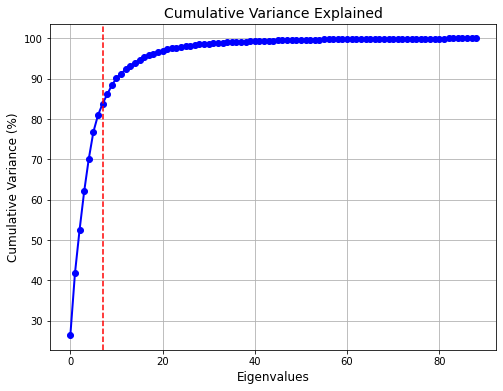

In [32]:
 # Plot cumulative variance explained
plt.figure(figsize=(8, 6))
plt.plot(acum, marker='o', linestyle='-', color='b', linewidth=2)
plt.xlabel("Eigenvalues", fontsize=12)
plt.ylabel("Cumulative Variance (%)", fontsize=12)
plt.title("Cumulative Variance Explained", fontsize=14)
plt.axvline(x=7, color='red', linestyle='--', label="Vertical line")
plt.grid()
plt.show()

Looking at the first three principal coordinates, does not give significant insight into how these principal coordinates can be interpreted. 

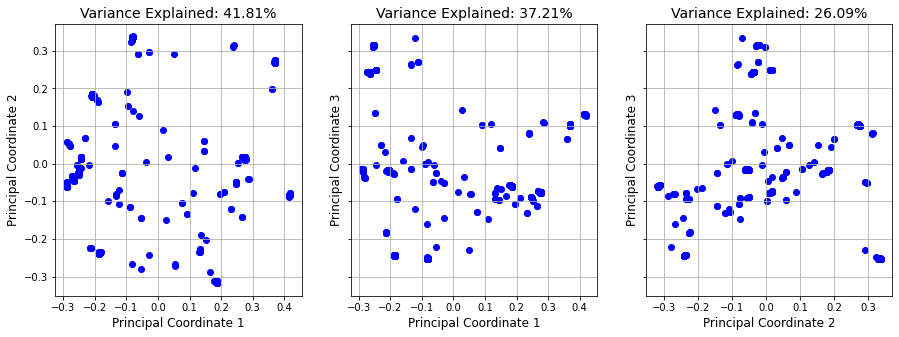

In [33]:
#for i in range(0,3):

#n  components
n_coords = 3
fig, axes = plt.subplots(1, n_coords, figsize=(15, 5), sharey=True)

axes[0].scatter(Y[:, 0], Y[:, 1], c='b', marker='o', label='Points')
axes[0].set_xlabel(f"Principal Coordinate {1}", fontsize=12)
axes[0].set_ylabel(f"Principal Coordinate {2}", fontsize=12)
axes[0].set_title(f"Variance Explained: {acum[1]:.2f}%", fontsize=14)
axes[0].grid()

axes[1].scatter(Y[:, 0], Y[:, 2], c='b', marker='o', label='Points')
axes[1].set_xlabel(f"Principal Coordinate {1}", fontsize=12)
axes[1].set_ylabel(f"Principal Coordinate {3}", fontsize=12)
axes[1].set_title(f"Variance Explained: {acum[0]+(acum[2]-acum[1]):.2f}%", fontsize=14)
axes[1].grid()

axes[2].scatter(Y[:, 1], Y[:, 2], c='b', marker='o', label='Points')
axes[2].set_xlabel(f"Principal Coordinate {2}", fontsize=12)
axes[2].set_ylabel(f"Principal Coordinate {3}", fontsize=12)
axes[2].set_title(f"Variance Explained: {acum[2]-acum[0]:.2f}%", fontsize=14)
axes[2].grid()


fig.show()

To gain a deeper understanding on how to interprete the principal coordinates, the same plot is done with a color coding of the categorical and the binary Variables.

- Gender is divided in the third quadrant with the males and higher values in the first and second coordinate with females.
- Occupation does not seems to have an specific order in any of the planes.
- Quality of sleep is slightly organize over the second coordinate, greater values of that axis represent a better quality of sleep.
- Strees level seems to have the opposite organization as quality of sleep (Higher values of the second axis represents lower values of stress level).
- BMI and Sleep Disorder are organized over the first axis.

This interpretations are an initial approach of how we can interpret the MDS, however we are going to check the influence of the Categorical variables.

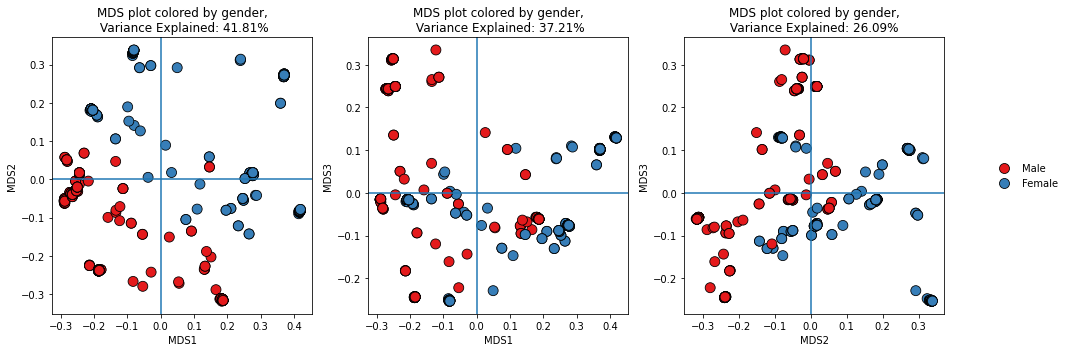

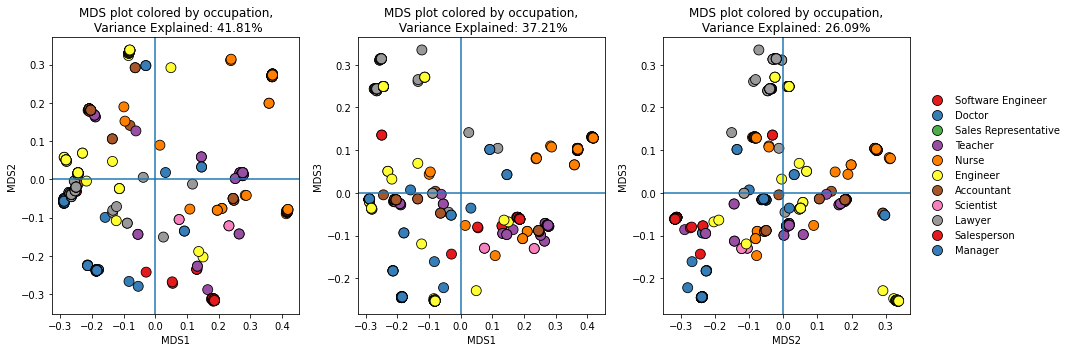

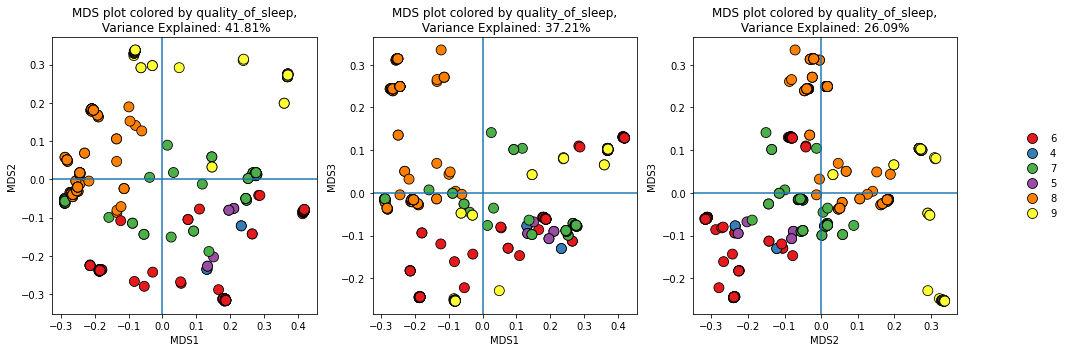

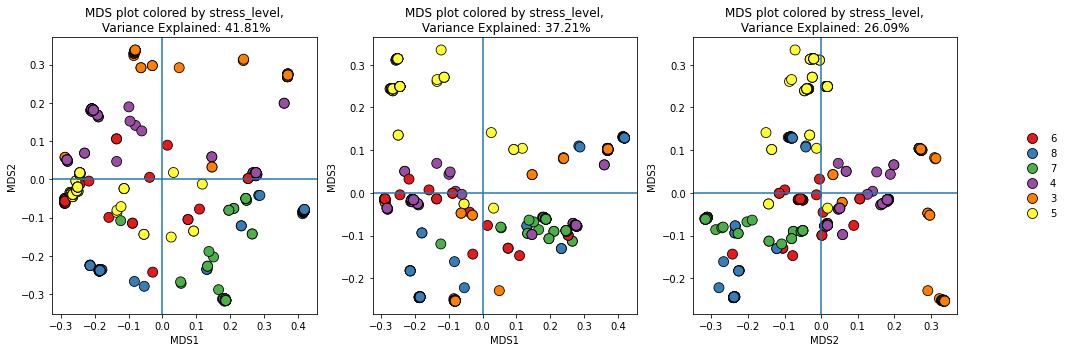

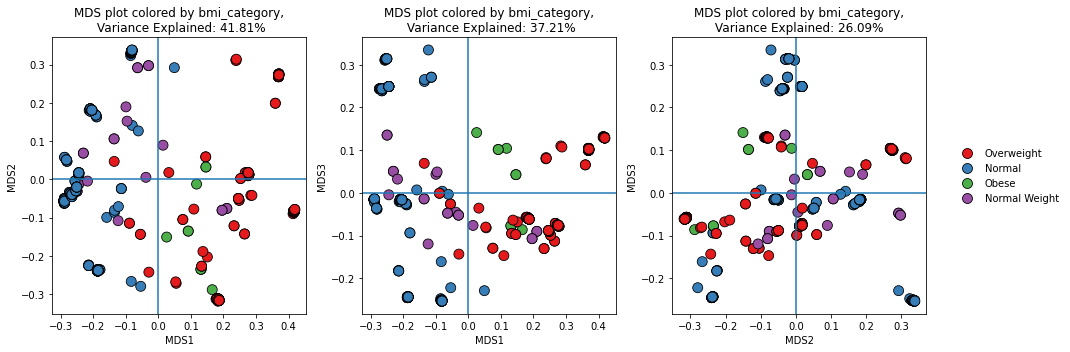

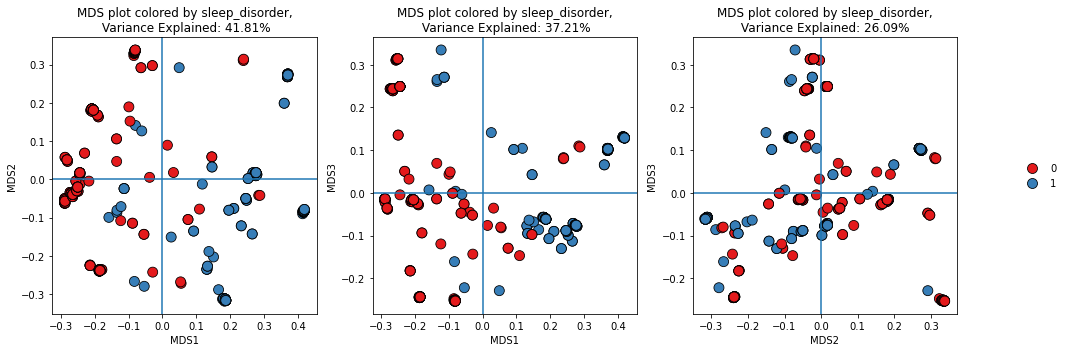

In [34]:
data_mds_output = data_mds.copy()
data_mds_output[["MDS1","MDS2","MDS3"]] = Y[:,0:3]

for i, var in enumerate(categorical_variables):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1, 0.2]})
    
    # MDS1 vs MDS2
    sns.scatterplot(
        ax=axes[0],
        data=data_mds_output,
        x='MDS1',
        y='MDS2',
        hue=var,
        palette='Set1',
        s=100,
        edgecolor='black'
    )
    axes[0].set_title(f'MDS plot colored by {var},\n Variance Explained: {acum[1]:.2f}%')
    axes[0].legend().set_visible(False) 

    
    # MDS1 vs MDS3
    sns.scatterplot(
        ax=axes[1],
        data=data_mds_output,
        x='MDS1',
        y='MDS3',
        hue=var,
        palette='Set1',
        s=100,
        edgecolor='black'
    )
    axes[1].set_title(f'MDS plot colored by {var},\n Variance Explained: {acum[0] + (acum[2] - acum[1]):.2f}%')
    axes[1].legend().set_visible(False) 

    # MDS2 vs MDS3
    sns.scatterplot(
        ax=axes[2],
        data=data_mds_output,
        x='MDS2',
        y='MDS3',
        hue=var,
        palette='Set1',
        s=100,
        edgecolor='black'
    )
    axes[2].set_title(f'MDS plot colored by {var},\n Variance Explained: {acum[2] - acum[0]:.2f}% ')
    axes[2].legend().set_visible(False) 

    # legend
    handles, labels = axes[0].get_legend_handles_labels()
    axes[3].legend(handles=handles, labels=labels, loc='center', frameon=False)
    axes[3].axis('off') 

    axes[0].axhline(0)
    axes[0].axvline(0)

    axes[1].axhline(0)
    axes[1].axvline(0)

    axes[2].axhline(0)
    axes[2].axvline(0)


    plt.tight_layout()
    plt.show()


Correlations between original Variables and first three Principal Coordinates

- __First axis:__ Blood pressure, BMI category and sleep disporder have a strong positive correlation.
- __Second axis:__ Sleep duration has the largest positive correlation and hear reat the largest negative one.
- __Third axis:__ Physical activity is the most important variable.

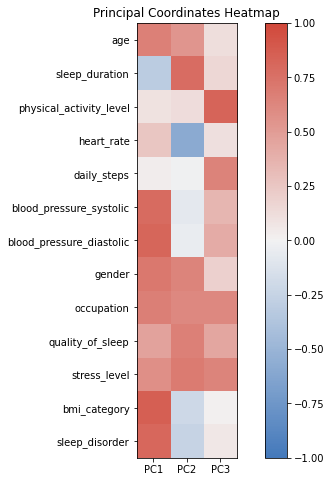

In [35]:
from scipy.stats import pearsonr, spearmanr
from scipy.stats import chi2_contingency

# Cramers V
def cramer_v(u, X):
    n = len(u)
    percentiles = np.percentile(X, [0, 25, 50, 75, 100])
    Xcat = np.ones(n)
    Xcat[(X > percentiles[1]) & (X <= percentiles[2])] = 2
    Xcat[(X > percentiles[2]) & (X <= percentiles[3])] = 3
    Xcat[X > percentiles[3]] = 4
    
    # contingency table
    cont_table = pd.crosstab(u, Xcat)
    chi2, p, dof, expected = chi2_contingency(cont_table)
    
    k = len(np.unique(u))
    r = len(np.unique(Xcat))
    
    V = np.sqrt(chi2 / (n * min(k - 1, r - 1)))
    return V

# Main correlation function
def correlaciones2(X, Y, pcuant, pnominal):
    collumns = X.columns
    
    X = X.to_numpy()
    p = X.shape[1]
    pordinal = p - pcuant - pnominal
    corr_table = np.zeros((p, 3))

    # quantitative variables
    for i in range(pcuant):
        corr_table[i, :] = [pearsonr(Y[:, 0], X[:, i])[0], pearsonr(Y[:, 1], X[:, i])[0], pearsonr(Y[:, 2], X[:, i])[0]]

    # nominal variables
    for i in range(pcuant, pcuant + pnominal):
        corr_table[i, :] = [cramer_v(X[:, i], Y[:, 0]), cramer_v(X[:, i], Y[:, 1]), cramer_v(X[:, i], Y[:, 2])]

    # ordinal variables
    for i in range(pcuant + pnominal, p):
        corr_table[i, :] = [spearmanr(Y[:, 0], X[:, i])[0], spearmanr(Y[:, 1], X[:, i])[0], spearmanr(Y[:, 2], X[:, i])[0]]

    # Plot
    L1 = ['PC1', 'PC2', 'PC3']    
    fig, ax = plt.subplots(figsize=(10, 8))
    cmap = sns.diverging_palette(250, 15, as_cmap=True)
    cax = ax.imshow(corr_table, cmap=cmap, vmin=-1, vmax=1)

    ax.set_xticks(np.arange(3))
    ax.set_xticklabels(L1)

    ax.set_yticks(np.arange(p))  # Set numeric tick positions
    ax.set_yticklabels(collumns)  # Use the actual column names as labels

    ax.set_title('Principal Coordinates Heatmap', fontsize=12)
    fig.colorbar(cax, ax=ax)
    
    plt.show()

    return corr_table



# excecute
corr_table = correlaciones2(X = data_mds[numeric_variables + categorical_variables],#.to_numpy(), 
               Y = Y[:,0:3], 
               pcuant = 7, 
               pnominal = 4)



From the Influence of Quantitative and Categorical Variables in the MDS configuration computed from Gower's distance we confirm the results obtained with the correlation matrix for the first two axes, and obtain more information:

- __Quantitative:__ On the first axis the most influential variables are the blood pressure (distolic and systolic) and the age. While in the second axis sleep duration and heart rate are the most important ones.

- __Qualitative:__ The second axis is clearly separated by quality of sleep and stress level. Lowe values of the first axis are influentiated by the gender and higher by the BMI category and sleep disorder.

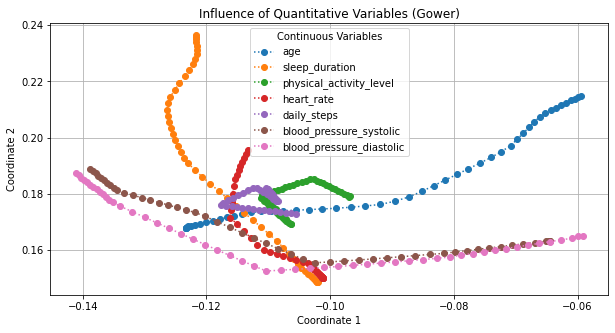

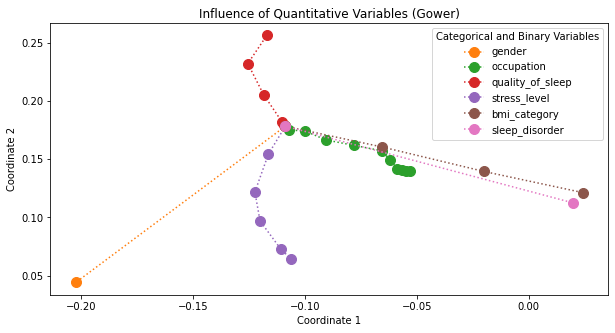

In [36]:
from scipy.spatial.distance import pdist, squareform
import matplotlib.cm as cm



def influence(X, p1, p2):
    columns = X.columns
    X = X.to_numpy()

    n, p = X.shape
    p3 = p - p1 - p2

    # Compute distance matrix
    if p2 + p3 == 0:
        D = squareform(pdist(X, metric='mahalanobis'))
        D2 = D ** 2
    else:
        D2 = gower.gower_matrix(data)


    # Principal coordinates
    Y, vaps, _, _ = coorp(D2)
    v = 1.0 / vaps[:Y.shape[1]]
    Lambda = np.diag(v)
    g = np.sum(Y ** 2, axis=1)

    m0 = np.min(X, axis=0)
    m1 = np.max(X, axis=0)

    # evaluate Influence of continious variables 
    for k in range(p1):
        step = (m1[k] - m0[k]) / 50
        Xnew = np.arange(m0[k], m1[k] + step, step).reshape(-1, 1)
        nXnew = Xnew.shape[0]
        virtual = np.zeros((nXnew, p))
        virtual[:, k] = Xnew[:, 0]

        dnew = np.zeros((nXnew, n))
        for i in range(nXnew):
            Xvirtual = np.vstack([X, virtual[i, :]])
            D2new = gower.gower_matrix(Xvirtual)
            dnew[i, :] = D2new[-1, :-1]

        ynew = np.zeros((nXnew, Y.shape[1]))
        for i in range(nXnew):
            ynew[i, :] = 0.5 * (g - dnew[i, :]) @ Y @ Lambda

        # plot
        plt.figure(1,figsize=(10,5))
        plt.plot(ynew[:, 0], ynew[:, 1],linestyle=':', label=f'{columns[k]}', marker='o')
        plt.legend(title="Continuous Variables", fontsize=10)
        plt.title("Influence of Quantitative Variables (Gower)", fontsize=12)
        plt.xlabel('Coordinate 1')
        plt.ylabel('Coordinate 2')
        plt.grid()

    # evaluate Influence of categorical/binary variables 
    plt.figure(figsize=(10,5))
    colors = cm.get_cmap('tab10') 
    for k in range(p1, p):

        # principalcoordinates
        Xnew = np.unique(X[:, k]) 
        nXnew = len(Xnew)
        virtual = np.zeros((nXnew, p))
        virtual[:, k] = Xnew
        dnew = np.zeros((nXnew, n))
        
        for i in range(nXnew):
            Xvirtual = np.vstack([X, virtual[i, :]]) 
            D2new = gower.gower_matrix(Xvirtual)  
            dnew[i, :] = D2new[-1, :-1]

        ynew = np.zeros((nXnew, Y.shape[1]))
        for i in range(nXnew):
            ynew[i, :] = 0.5 * (g - dnew[i, :]) @ Y @ Lambda

        # plot
        plt.plot(
            ynew[:, 0], ynew[:, 1], linestyle=':', marker='o', markersize=10, 
            label=f'{columns[k]}', color=colors(k-6)
        )
        plt.title(f'Influence of Categorical and Binary Variables (Gower)')
        plt.legend(title="Categorical and Binary Variables", fontsize=10)
        plt.title("Influence of Quantitative Variables (Gower)", fontsize=12)
        plt.xlabel('Coordinate 1')
        plt.ylabel('Coordinate 2')
        plt.grid()

plt.show()

# encode categorical/binaryvariables 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data_encoded = data_mds.copy()
for col in categorical_variables:
    data_encoded[col] = label_encoder.fit_transform(data[col])


# run
influence(X=data_encoded[numeric_variables+categorical_variables], p1= 7, p2 = 4)



## Conclusion

Looking at the findings of the Multi Dimensiona Scaling with Gowers distance, it is apparent that the MDS compared to the PCA, is not able to contain as much of the information (variance) in a small number of variables. Where the PCA was able to represent 90 % of the variability with 3 principal components, the MDS requires 6 principal coordinates to represent 80% of the variability with significant more to reach the respective 90%. With a total of 13 Variables, when the objective is the maximum possible dimension reduction, MDS thus appear to be the significantly better approach. None the less, the interpretability of the resulting new dimensions might however favour MDS, where the Influence of the categorical variables shows to be nearly orthogonal for the PC1 vs PC2 dimensions. 

The MDS could be further improved by modifying its configuration with new distance types as done in ReIMS, using different distances from the traditional Gower's distance to archieve greater robustness & stability. This however would not change the fact, that PCA appears to be better fit for dimension reduction in this particular data set. 
